In [113]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk

from glob import glob

import numpy as np

from scipy.ndimage import shift

In [114]:
template_mask = sitk.GetArrayFromImage(sitk.ReadImage("tmp.nii.gz"))

base_dir = "/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test"
input_paths = glob(os.path.join(base_dir, "*", "*_scaled.nii.gz"))
print(input_paths)


imgs = []
for path in input_paths:
    img = sitk.GetArrayFromImage(sitk.ReadImage(path))
    # 只取第一张 非门控图
    imgs.append(img[0])
    
input_img1, input_img2, input_img3, input_img4, input_img5 = imgs

print(template_mask.shape, input_img1.shape)

['/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/001398670/270_From_SA_scaled.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002478508/460_From_SA_scaled.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002640212/1278_From_SA_scaled.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002657146/1787_From_SA_scaled.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/000652515/161_From_SA_scaled.nii.gz']
(60, 51, 60) (60, 63, 60)


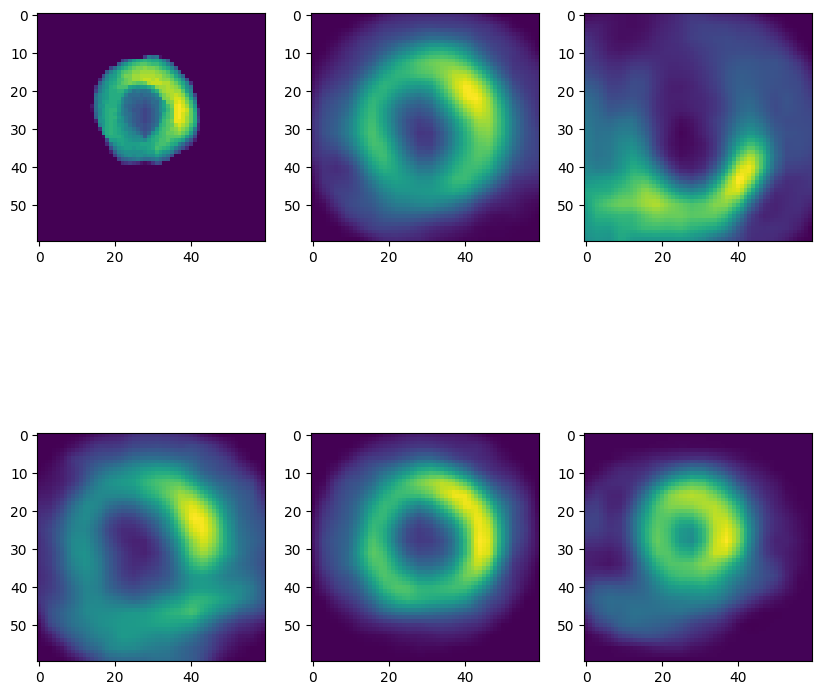

In [115]:
template_mask2d = template_mask.sum(axis=1)

fig = plt.figure(figsize=(10,10))

plt.subplot(231)
plt.imshow(template_mask.sum(axis=1))

for i in range(5):
    plt.subplot(2,3, i+2)
    
    plt.imshow(imgs[i].sum(axis=1))


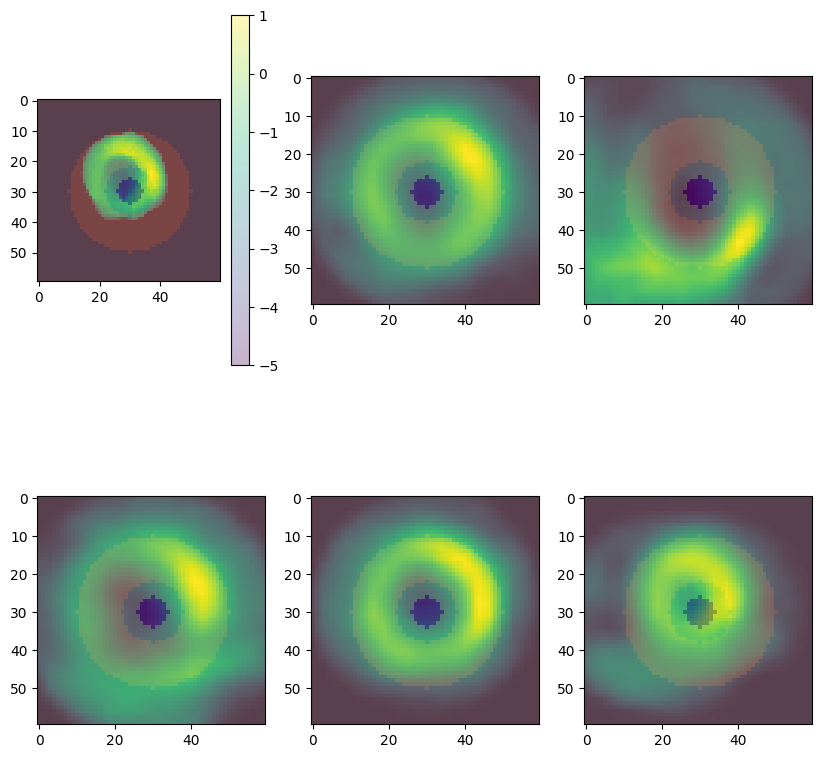

In [116]:
def generate_annular_mask(shape, center, r1, r2):
    y, x = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    mask = np.zeros(shape, dtype=np.float32)
    
    r1_in, r1_out = r1
    mask[dist_from_center <= r1_out] = -1
    
    
    r2_in, r2_out = r2
    mask[(dist_from_center <= r2_out) & (dist_from_center > r2_in)] = 1
    
    
    filt_r1 = mask==-1
    r1_sum = np.sum(filt_r1)
    filt_r2 = mask==1
    r2_sum = np.sum(filt_r2)
    
    mask[filt_r1] = -r2_sum/r1_sum * 2
    
    return mask

# 定义图像大小和圆心
shape = (48, 48)  # 图像大小 y* x
center = (24, 24)    # 圆心 y, x
r1 = (0,4)
r2 = (8,20)

# 生成mask
mask = generate_annular_mask(shape, center, r1, r2)

def expand_mask(mask, new_shape):
    old_shape = mask.shape
    diff_y = new_shape[0] - old_shape[0]
    pad_y1, pad_y2 = diff_y//2, diff_y-diff_y//2
    
    
    diff_x = new_shape[1] - old_shape[1]
    pad_x1, pad_x2 = diff_x//2, diff_x-diff_x//2
    
    expanded_mask = np.pad(mask, ((pad_y1, pad_y2), (pad_x1, pad_x2)), mode='constant', constant_values=0)
    return expanded_mask

fig = plt.figure(figsize=(10,10))

template_mask2d = template_mask.sum(axis=1)
expanded_mask = expand_mask(mask, template_mask2d.shape)
plt.subplot(231)
plt.imshow(template_mask2d)
plt.imshow(expanded_mask, alpha=0.3, vmin=-5)
plt.colorbar()

for i in range(5):
    plt.subplot(2,3, i+2)
    
    img2d = imgs[i].sum(axis=1)
    expanded_mask = expand_mask(mask, img2d.shape)
    plt.imshow(img2d)
    plt.imshow(expanded_mask, alpha=0.3, vmin=-5)

plt.show()



1 -1
6 -3
0 -3
-3 -1
-3 -3


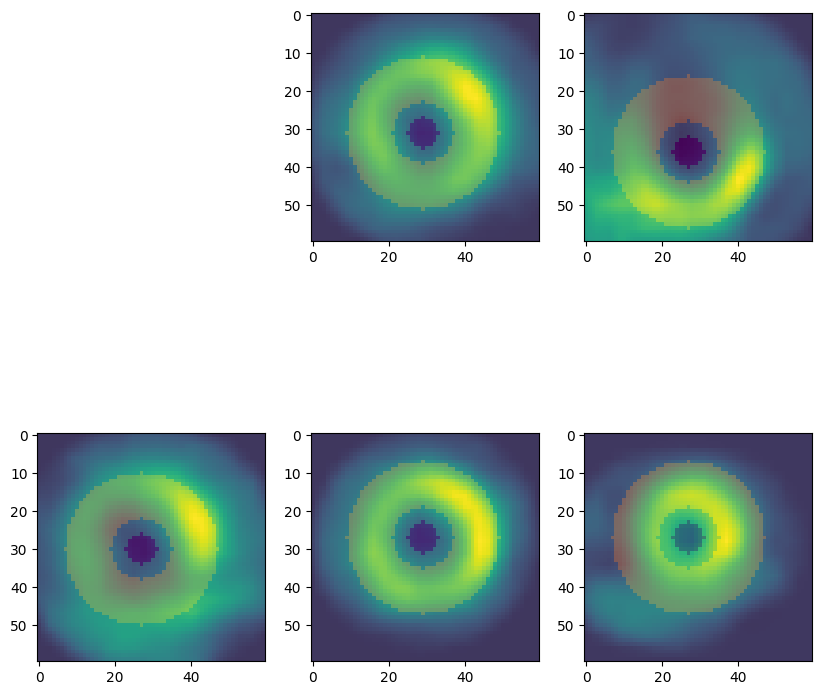

In [158]:
### 匹配圆心

def generate_shifted_masks(mask, shift_px):
    shifted_masks = np.zeros((2 * shift_px + 1, 2 * shift_px + 1, *mask.shape), dtype=np.float32)
    shifted_penalties = np.zeros((2 * shift_px + 1, 2 * shift_px + 1), dtype=np.float32)
    
    for i, dx in enumerate(range(-shift_px, shift_px + 1)):
        for j, dy in enumerate(range(-shift_px, shift_px + 1)):
            shifted_masks[i, j] = shift(mask, shift=(dy, dx), mode='constant', cval=0)
            shifted_penalties[i,j] = -0.1*(abs(dx*dx*dx*dx) + abs(dy*dy*dy*dy))
    
    return shifted_masks, shifted_penalties



# fig = plt.figure(figsize=(15,15))

fig = plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(2,3, i+2)
    
    img2d = imgs[i].sum(axis=1)
    
    
    # print(img2d.shape)
    # shape = img2d.shape
    # y, x = np.ogrid[:shape[0], :shape[1]]
    
    # # 计算圆的半径和中心
    # radius = min(shape) // 2
    # center_y, center_x = np.array(shape)/2
    
    # out_mask = (x - center_x) ** 2 + (y - center_y) ** 2 > radius ** 2
    
    # img2d[out_mask] = 0
    
    # # plt.imshow(img2d)
    # scale = np.percentile(img2d[~out_mask], 99)
    # img2d = np.clip(img2d/scale, 0, 1)
    
    
    
    
    
    expanded_mask = expand_mask(mask, img2d.shape)
    
    search_range = 8
    shifted_masks, penalties = generate_shifted_masks(expanded_mask, search_range)
    
    # plt.imshow(penalties)
    # plt.colorbar()

    
    conv_scores = np.tensordot(shifted_masks, img2d, axes=([2, 3], [0, 1]))
    scores = conv_scores+0
    
    # plt.imshow(scores)
    # plt.colorbar()
    
    
    best_score_index = np.unravel_index(np.argmax(scores),scores.shape)
    shift_x, shift_y = np.array(best_score_index) - search_range
    print(shift_y, shift_x)
    
    best_mask = shift(expanded_mask, shift=(shift_y, shift_x), mode='constant', cval=0)
    
    # best_mask = shifted_masks[best_score_index]
    
    plt.imshow(img2d)
    plt.imshow(best_mask, alpha=0.3, vmin=-2)
    
    # break
    
    
    


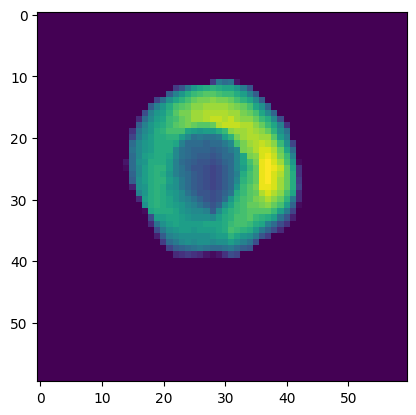

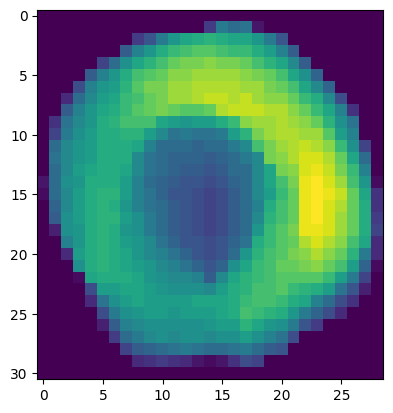

In [146]:
template_mask2d

plt.imshow(template_mask2d)
plt.show()


template_mask2d_new = template_mask2d[10:41,14:43]

plt.imshow(template_mask2d_new)

1 -1
6 -3
0 -3
-3 -1
-3 -3


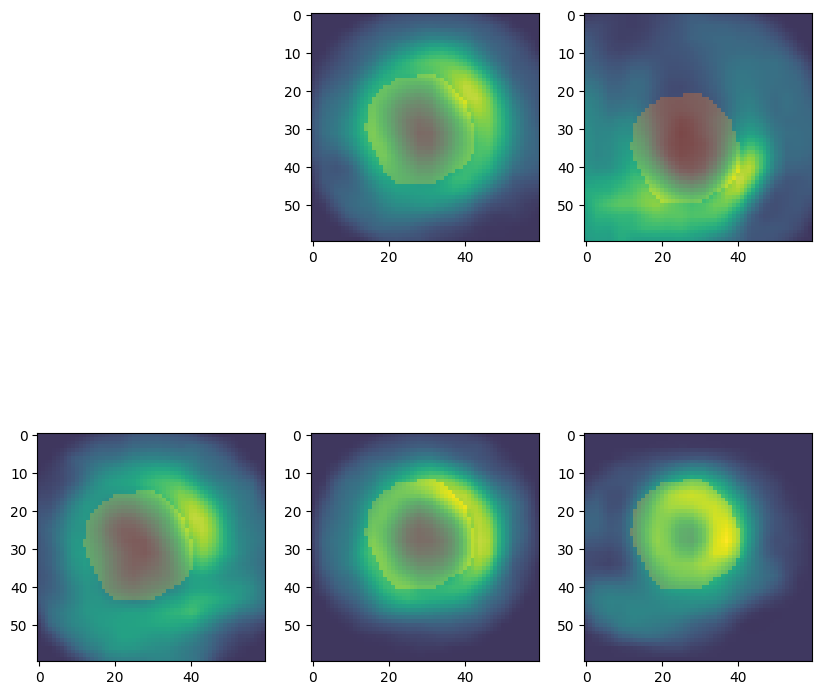

In [159]:
fig = plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(2,3, i+2)
    
    img2d = imgs[i].sum(axis=1)
    
    
    # print(img2d.shape)
    # shape = img2d.shape
    # y, x = np.ogrid[:shape[0], :shape[1]]
    
    # # 计算圆的半径和中心
    # radius = min(shape) // 2
    # center_y, center_x = np.array(shape)/2
    
    # out_mask = (x - center_x) ** 2 + (y - center_y) ** 2 > radius ** 2
    
    # img2d[out_mask] = 0
    
    # # plt.imshow(img2d)
    # scale = np.percentile(img2d[~out_mask], 99)
    # img2d = np.clip(img2d/scale, 0, 1)
    
    
    
    
    
    expanded_mask = expand_mask(mask, img2d.shape)
    
    search_range = 8
    shifted_masks, penalties = generate_shifted_masks(expanded_mask, search_range)
    
    # plt.imshow(penalties)
    # plt.colorbar()

    
    conv_scores = np.tensordot(shifted_masks, img2d, axes=([2, 3], [0, 1]))
    scores = conv_scores+0
    
    # plt.imshow(scores)
    # plt.colorbar()
    
    
    best_score_index = np.unravel_index(np.argmax(scores),scores.shape)
    shift_x, shift_y = np.array(best_score_index) - search_range
    print(shift_y, shift_x)
    
    
    expanded_mask2 = expand_mask(template_mask2d_new, img2d.shape)
    best_mask2 = shift(expanded_mask2, shift=(shift_y, shift_x), mode='constant', cval=0)
    # best_mask = shifted_masks[best_score_index]
    
    plt.imshow(img2d)
    plt.imshow(best_mask2, alpha=0.3, vmax=1, vmin=-2)
    
    
    # break
    
    
    


In [98]:
# import numpy as np
# from scipy.ndimage import zoom, shift
# from skimage.metrics import normalized_mutual_information
# from skimage.measure import label, regionprops

# def dice_coefficient(mask, image):
#     """计算二值图像和浮点图像之间的Dice系数"""
#     image_bin = (image > 0.5).astype(np.int8)  # 对图像进行阈值化
#     intersection = np.sum(mask * image_bin)
#     return 2 * intersection / (np.sum(mask) + np.sum(image_bin))

# def resize_image_to_mask(image, mask):
#     """调整图像大小以匹配掩膜的大小"""
#     target_shape = mask.shape
#     return zoom(image, (target_shape[0] / image.shape[0], target_shape[1] / image.shape[1], target_shape[2] / image.shape[2]))

# def register_3d_images(target_image, reference_mask):
#     """
#     使用平移、缩放等变换对三维心脏图像与二值掩膜进行配准
#     :param target_image: 目标三维心脏图像（float类型）
#     :param reference_mask: 标准三维心脏掩膜（0/1 二值图）
#     :return: 与目标图像配准的掩膜
#     """
#     # 步骤 1: 归一化输入图像
#     target_image = target_image / np.max(target_image)
#     reference_mask = reference_mask.astype(np.float32)

#     # 步骤 2: 定义Dice系数度量
#     def evaluate_alignment(image, mask):
#         return dice_coefficient(mask, image)

#     # 步骤 3: 粗略平移配准
#     best_shift = None
#     best_score = 0  # Dice系数最大化
    
#     search_range = range(-1, 2)
#     for tx in search_range:  # 范围可以根据需要扩展
#         for ty in search_range:
#             for tz in search_range:
#                 shifted_image = shift(target_image, (tx, ty, tz))  # 3D平移
#                 score = evaluate_alignment(shifted_image, reference_mask)
#                 if score > best_score:
#                     best_score = score
#                     best_shift = (tx, ty, tz)
#     print('done')

#     # 步骤 4: 缩放配准
#     best_scale = 1
#     best_score = 0
#     for scale in np.linspace(0.8, 1.2, 10):
#         scaled_image = zoom(target_image, (scale, scale, scale), mode='nearest')
#         # 确保缩放后的图像与掩膜大小一致
#         scaled_image_resized = resize_image_to_mask(scaled_image, reference_mask)
#         score = evaluate_alignment(scaled_image_resized, reference_mask)
#         if score > best_score:
#             best_score = score
#             best_scale = scale

#     # 步骤 5: 生成与目标图像匹配的掩膜
#     final_image = shift(target_image, best_shift, mode='nearest')
#     final_image = zoom(final_image, (best_scale, best_scale, best_scale), mode='nearest')

#     # 确保最终图像与掩膜大小一致
#     final_image_resized = resize_image_to_mask(final_image, reference_mask)

#     # 将配准后的图像转换为二值掩膜
#     final_mask = (final_image_resized > 0.5).astype(np.int8)  # 根据阈值生成二值掩膜

#     return final_mask



# input_img_scaled = input_img[0] / np.max(input_img[0])


# out_mask = register_3d_images(input_img_scaled, template_mask)